<a href="https://colab.research.google.com/github/van-dang/FEniCS-Colab/blob/master/TestODECoupling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the code
This is a simple version of adaptive theta-method following the instructions at

https://buildmedia.readthedocs.org/media/pdf/fenics-handson/latest/fenics-handson.pdf


In [2]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *

gmsh_dir=!which gmsh
if len(gmsh_dir)==0:
  !apt-get install gmsh
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

clear_output()

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

# Disable warnings
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger("rothemain.rothe_utils")
logging.getLogger('UFL').setLevel(logging.WARNING)
logging.getLogger('FFC').setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore")


dolfin version: 2019.1.0


t= 100.14783604605572 , error:  0.09757046095762162 , |ue|= 23.897374034685416
t= 100.0 , elapsed time= 76.82725191116333
|u-ue|: 9.757046e-02, |ue|: 2.389737e+01, mean(dt): 3.330000e+00, num_steps: 574


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


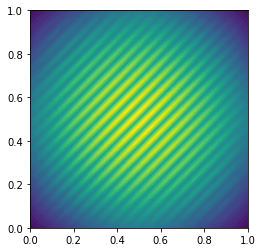

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


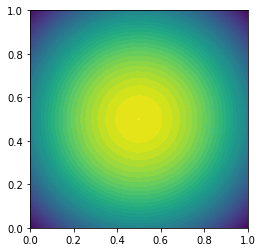

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


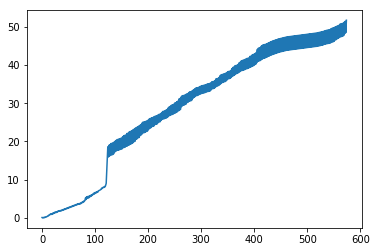

In [155]:
from fenics import *
import numpy as np
from scipy.integrate import ode
from scipy.integrate import odeint


T = 100.0            # final time
num_steps = 32     # number of time steps
dt = 3.33 # T/num_steps       # time step size
kcoeff = 3e-3      # diffusion coefficient
gamma = 1e-16

# Create mesh and define function space
nx = ny = 32
mesh = UnitSquareMesh(nx, ny)
V = FunctionSpace(mesh, 'CG', 1)

t0 = 1e-1
# Define boundary condition
u_D = Expression('1/(4*k*t)*exp( (-(x[0]-x0)*(x[0]-x0)-(x[1]-y0)*(x[1]-y0))/(4*k*t) )', degree=2, t=t0, x0=0.5, y0=0.5, k=kcoeff)
duD_dt = Expression('(exp(-((x[0] - x0)*(x[0] - x0) + (x[1] - y0)*(x[1] - y0))/(4*k*t))*((x0-x[0])*(x0-x[0]) + (x[1]-y0)*(x[1]-y0) - 4*k*t))/(16*k*k*t*t*t)', degree=2, t=t0, x0=0.5, y0=0.5, k=kcoeff)


def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, duD_dt, boundary)

# Define initial value
u_D.t = t0;
u0 = interpolate(u_D, V)

# print(u0.vector().norm("l2"));
# stop


# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)

mass_form = u*v*dx
M = assemble(mass_form)


mass_action_form = action(mass_form, Constant(1))

M_lumped = assemble(mass_form)
M_lumped.zero()

b=assemble(mass_action_form)
b_inv = Vector(b)
b_inv[:] = np.divide(1,b[:])

M_lumped.set_diagonal(b_inv)
bc.apply(M_lumped)


def f(t, u0):
    #t1 = time.time()
    duD_dt.t = t;
    u = Function(V);
    u.vector()[:] = u0
    r = - kcoeff*dot(grad(u), grad(v))*dx #+ (beta - 2 - 2*alpha)*v*dx# - gamma*u*v*theta*dx + gamma*u_D*v*theta*dx
    b = assemble(r)
    bc.apply(b)
    #print("f.time:",time.time()-t1)
    return M_lumped*b
  
def jac(t, u0):
    #t1 = time.time()
    u = TrialFunction(V);
    r = - kcoeff*dot(grad(u), grad(v))*dx # - gamma*u*v*theta*dx
    #print("jac.time:",time.time()-t1)
    return np.multiply(M_lumped.array(),assemble(r).array())
  
ode15s = ode(f, jac).set_integrator('vode', rtol=1e-1,atol=1e-1,method='bdf', with_jacobian=True)
# ode15s = ode(f).set_integrator('vode', rtol=1e-14,atol=1e-14, method='bdf', with_jacobian=False)
ode15s.set_initial_value(u0.vector(), t0)

start_time = time.time()
tarray=[t0];

num_steps = 0;
while ode15s.successful() and ode15s.t < T:
    ode15s.integrate(T, step=True) 
    tarray.append(ode15s.t-tarray[-1])
    num_steps += 1;
    
elapsed_time = time.time() - start_time  
    
u0.vector()[:] = ode15s.y
plot(u0)    

u_D.t = ode15s.t;
ue= interpolate(u_D, V)
plt.figure()
plot(ue)

est = sqrt(assemble((u0 - u_D)**2*dx))
print("t=",ode15s.t,", error: ",est, ", |ue|=",ue.vector().norm("l2"))
print('t=',t,', elapsed time=',elapsed_time)      
print("|u-ue|: %e, |ue|: %e, mean(dt): %e, num_steps: %d"%(est, ue.vector().norm('l2'), np.mean(dt_array), num_steps))

plt.figure();
plt.plot(tarray)

t= 100.0 , elapsed time= 2.2473933696746826
|u-ue|: 2.158171e-03, |ue|: 2.392808e+01, mean(dt): 3.330000e+00, num_steps: 32


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


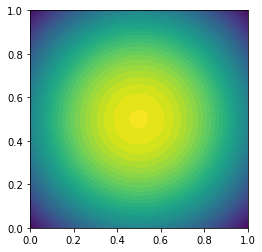

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


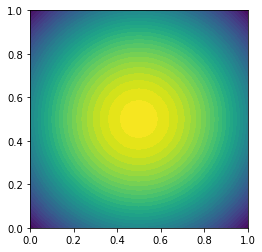

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


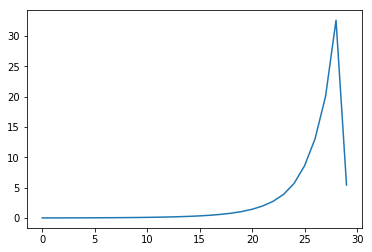

In [152]:
from fenics import *
import numpy as np


#class AdaptiveThetaMethod:
#    def __init__(self, V, dUdt):
#        self.dUdt = dUdt
#        self.V = V
#        
#        self.M = assemble(u*v*dx)

        
def compute_est(theta, u_L, u_H):
    """Return error estimate by Richardson extrapolation"""
    p = 2 if theta == 0.5 else 1
    est = sqrt(assemble((u_L - u_H)**2*dx)) / (2**p - 1)
    return est

def compute_new_dt(theta, est, tol, dt):
    """Return new time step"""
    p = 2 if theta == 0.5 else 1
    rho = 0.9
    dt_new = dt * ( rho * tol / est )**(1/p)
    return dt_new

def single_step(theta, t, dt, u0, dUdt):
  u = TrialFunction(V)
  M = assemble(u*v*dx)
  r = dUdt(theta, t, u) + dUdt(1-theta, t, u0)
  A = 1./dt*M - assemble(lhs(r))
  b = 1./dt*M*u0.vector() - assemble(rhs(r))
  u_D.t = t;
  bc.apply(A, b)
  u = Function(V)
  linsolver.solve(A, u.vector(), b)
  return u
  
  
T = 100.0            # final time
num_steps = 50     # number of time steps
dt = 3.33 # T/num_steps       # time step size
kcoeff = 3e-3      # diffusion coefficient

# Create mesh and define function space
nx = ny = 32
mesh = UnitSquareMesh(nx, ny)
V = FunctionSpace(mesh, 'CG', 1)

t0 = 1e-1
# Define boundary condition
u_D = Expression('1/(4*k*t)*exp( (-(x[0]-x0)*(x[0]-x0)-(x[1]-y0)*(x[1]-y0))/(4*k*t) )', degree=2, t=t0, x0=0.5, y0=0.5, k=kcoeff)


def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

# Define initial value
u_D.t = t0;
u0 = interpolate(u_D, V)


# Define variational problem
ut = TrialFunction(V)
v = TestFunction(V)

linsolver = KrylovSolver("bicgstab","jacobi")
linsolver.parameters["relative_tolerance"] = 1e-6
linsolver.parameters["absolute_tolerance"] = 1e-10
linsolver.parameters["maximum_iterations"] = 100000
parameters['krylov_solver']['nonzero_initial_guess'] = True

theta = 0.5;
gamma = 1e-16;
tol = 1e-2;

def dUdt(theta, t, u):
  u_D.t = t;  
  r = - kcoeff*dot(grad(u), grad(v))*theta*dx - gamma*u*v*theta*dx + gamma*u_D*v*theta*dx
  return r

u = Function(V)

t = t0;

start_time = time.time()
num_steps = 0;

dt_array=[];
while t<T:
  u_low    = single_step(theta, t + dt,         dt,   u0, dUdt)
  if 1==1:
    u_mid  = single_step(theta, t + 0.5*dt,    dt/2, u0, dUdt)
    u_high = single_step(theta, t + dt,  dt/2, u_mid, dUdt)
    est = compute_est(theta, u_low, u_high)
    dt_new = compute_new_dt(theta, est, tol, dt)
    dt_new = min(dt_new, T-t)
    num_steps +=1;
    # print(est, dt_new, t)
    if est > tol:
        dt = min(dt_new, T-t)
    else:
        t += dt
        dt_array.append(dt)
        dt = min(dt_new, T-t)
        u0.vector()[:] = u_high.vector()[:]
  else:
    num_steps +=1;
    t += dt
    dt_array.append(dt)
    u0.vector()[:] = u_low.vector()[:]

elapsed_time = time.time() - start_time  
print('t=',t,', elapsed time=',elapsed_time)      
u_D.t = t;
ue = interpolate(u_D,V)
# est = compute_est(theta, ue, u0)
est = sqrt(assemble((u0 - ue)**2*dx))


print("|u-ue|: %e, |ue|: %e, mean(dt): %e, num_steps: %d"%(est, ue.vector().norm('l2'), np.mean(dt_array), num_steps))

plot(ue)
plt.figure();
plot(u0)
plt.figure();
plt.plot(dt_array)


In [0]:
!python3 -m cProfile test_ode.py 1>log_profile